<a href="https://colab.research.google.com/github/Fredybec/security3/blob/main/TP1_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP1 : Prediction du taux de desabonnement pour Les clients de Telco

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## Visualisation des donnees et etude statistiques

Chargement du dataset dans l'espace de travail

In [2]:
df = pd.read_csv(r"drive/MyDrive/DataMining/data.csv")

print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

On remarque que la colonne customerID doit etre supprimer et qu'on doit modifier le type de la colonne TotalCharges, on doit aussi verifier qu'on a pas de valeurs nulles.

In [3]:
df = df.drop(['customerID'], axis = 1)
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors = 'coerce')
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

La variable TotalCharges contient 11 valeurs nulles , on doit regler le probleme avant de proceder dans l'analyse. Ce qu'on propose c'est de remplir les valeurs manquantes par la moyenne de TotalCharges.

In [4]:
df[np.isnan(df['TotalCharges'])]

df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)
df[df['tenure'] == 0]

df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

On change le type des variables categorielles.

In [5]:
cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

df[cols] = df[cols].astype('category')

for column in cols:
    df[column] = df[column].cat.codes

print(df.dtypes)

gender                 int8
SeniorCitizen          int8
Partner                int8
Dependents             int8
tenure                int64
PhoneService           int8
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling       int8
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                  int8
dtype: object


On procede maintenant a l'analyse , on commence par determiner le pourcentage des hommes et femmes ainsi que le pourcentage des personnes qui annulent l'abonnement (churn)

In [6]:
g_labels = ['Homme', 'Femme']
c_labels = ['Non', 'Oui']

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=g_labels, values=df['gender'].value_counts(), name="Gender"),1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=df['Churn'].value_counts(), name="Churn"),1, 2)
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(title_text="Distribution de sexe et desabonnement",annotations=[dict(text='SEXE', x=0.16, y=0.5, font_size=20, showarrow=False),dict(text='DESABONNEMENT', x=0.84, y=0.5, font_size=20, showarrow=False)])
fig.show()

On remarque que 49.5% sont des femmes et que 50.5% sont des hommes ce qui veut dire qu'il y a une egalite entre les deux sexes.
On remarque aussi que 26.5% des clients ont change de fournisseur.

In [7]:
fig = px.histogram(df, x="Churn", color="Contract", barmode="group", title="<b>Distribution Client Contrat<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

D'apres cet histogramme on remarque que la majorite des clients qui se sont desabonnes ont un abonnement mois par mois

In [8]:
labels = df['PaymentMethod'].unique()
values = df['PaymentMethod'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Distribution de la methode de paiement</b>")
fig.show()

On remarque que la methode de paiement la plus utilise est cheque electronique.

In [9]:
fig = px.histogram(df, x="Churn", color="PaymentMethod", title="<b>Distribution de la methode de paiement par desabonnement</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Les clients qui se desabonnent le plus sont les clients avec cheque electronique comme methode de paiaement par contre ceux avec Mailed check, Bank Transfer ou Carte bancaire ne se desabonnent pas trop.

In [10]:
fig = go.Figure()

fig.add_trace(go.Bar( x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],["Female", "Male", "Female", "Male"]],y = [965, 992, 219, 240],name = 'DSL',))

fig.add_trace(go.Bar(x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],["Female", "Male", "Female", "Male"]],y = [889, 910, 664, 633],name = 'Fiber optic',))

fig.add_trace(go.Bar(x = [['Churn:No', 'Churn:No', 'Churn:Yes', 'Churn:Yes'],["Female", "Male", "Female", "Male"]],y = [690, 717, 56, 57],name = 'No Internet',))

fig.update_layout(title_text="<b>Distribution de desabonnement par rapport au service internet et sexe</b>")

fig.show()

Beaucoup de clients opte pour le fibre optique , et ce service a un grand taux de desabonnement ce qui explique que les clients ne sont pas satisfait par ce service.Par contre la majorite a un service de DSL et ont un taux de desabonnement inferieur.

In [11]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(df, x="Churn", color="Dependents", barmode="group", title="<b>Distribution de dependants</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

La majorite des clients qui se desabonnent n'ont pas de dependant.

In [14]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df, x="Churn", color="Partner", barmode="group", title="<b>Distribution de desabonnement par rapport au partenaire</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Les clients qui n'ont pas de partenaire ont une tendance a se desabonner.

In [15]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df, x="Churn", color="SeniorCitizen", title="<b>Distribution de desabonnement par rapport aux clients vieux</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

On remarque qu'on a peu de clients vieux et que la majorite d'entre eux se desabonnent.

In [16]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}
fig = px.histogram(df, x="Churn", color="OnlineSecurity", barmode="group", title="<b>Desabonnement par rapport a la securite en ligne</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

La majorite des clients qui se desabonnent n'ont pas de securite en ligne.

In [17]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}
fig = px.histogram(df, x="Churn", color="PaperlessBilling",  title="<b>Desabonnement par rapport a la facturation electronique (sans papier)</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

La majorite des clients avec facturation electronique se desabonnent.

In [18]:
fig = px.histogram(df, x="Churn", color="TechSupport",barmode="group",  title="<b>Desabonnement par rapport au tech support</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Les clients sans TechSupport ont une tendance a se desabonner.

In [19]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df, x="Churn", color="PhoneService", title="<b>Desabonnement par rapport au service Mobile</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Peu de clients n'ont pas de service mobile et 1/3 d'entre eux se desabonnent.

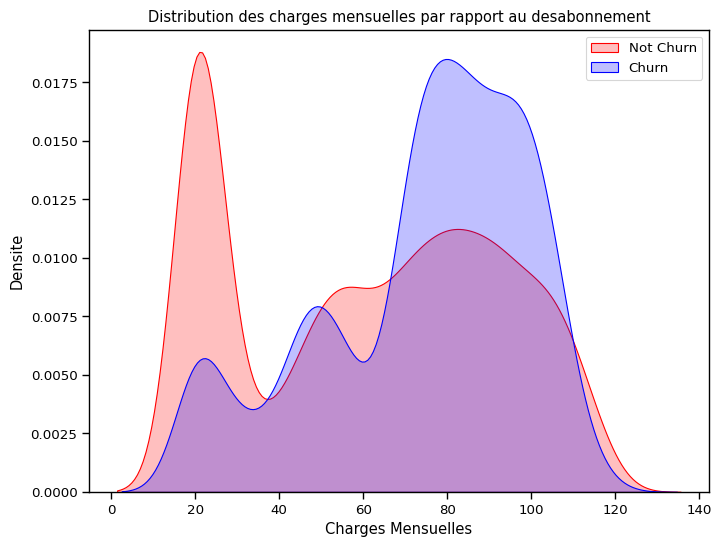

In [20]:
sns.set_context("paper", font_scale=1.1)
plt.figure(figsize=(8, 6))

sns.kdeplot(df.MonthlyCharges[df['Churn'] == 0], color='red', label='Not Churn', shade=True)

sns.kdeplot(df.MonthlyCharges[df['Churn'] == 1], color='blue', label='Churn', shade=True)

plt.xlabel('Charges Mensuelles')
plt.ylabel('Densite')
plt.title('Distribution des charges mensuelles par rapport au desabonnement')
plt.legend()

plt.show()

Les clients avec des frais mensuelles eleves ont tendance a se desabonner.

In [21]:
fig = px.box(df, x='Churn', y = 'tenure')

fig.update_yaxes(title_text='Fidelite (Mois)', row=1, col=1)
fig.update_xaxes(title_text='Desabonnement', row=1, col=1)

fig.update_layout(autosize=True, width=750, height=600,title_font=dict(size=25, family='Courier'), title='<b>Fidelite vs Desabonnement</b>',)

fig.show()

Les nouveaux clients se desabonnent plus que les anciens.

Text(0.5, 1.0, 'Correlation avec desabonnement')

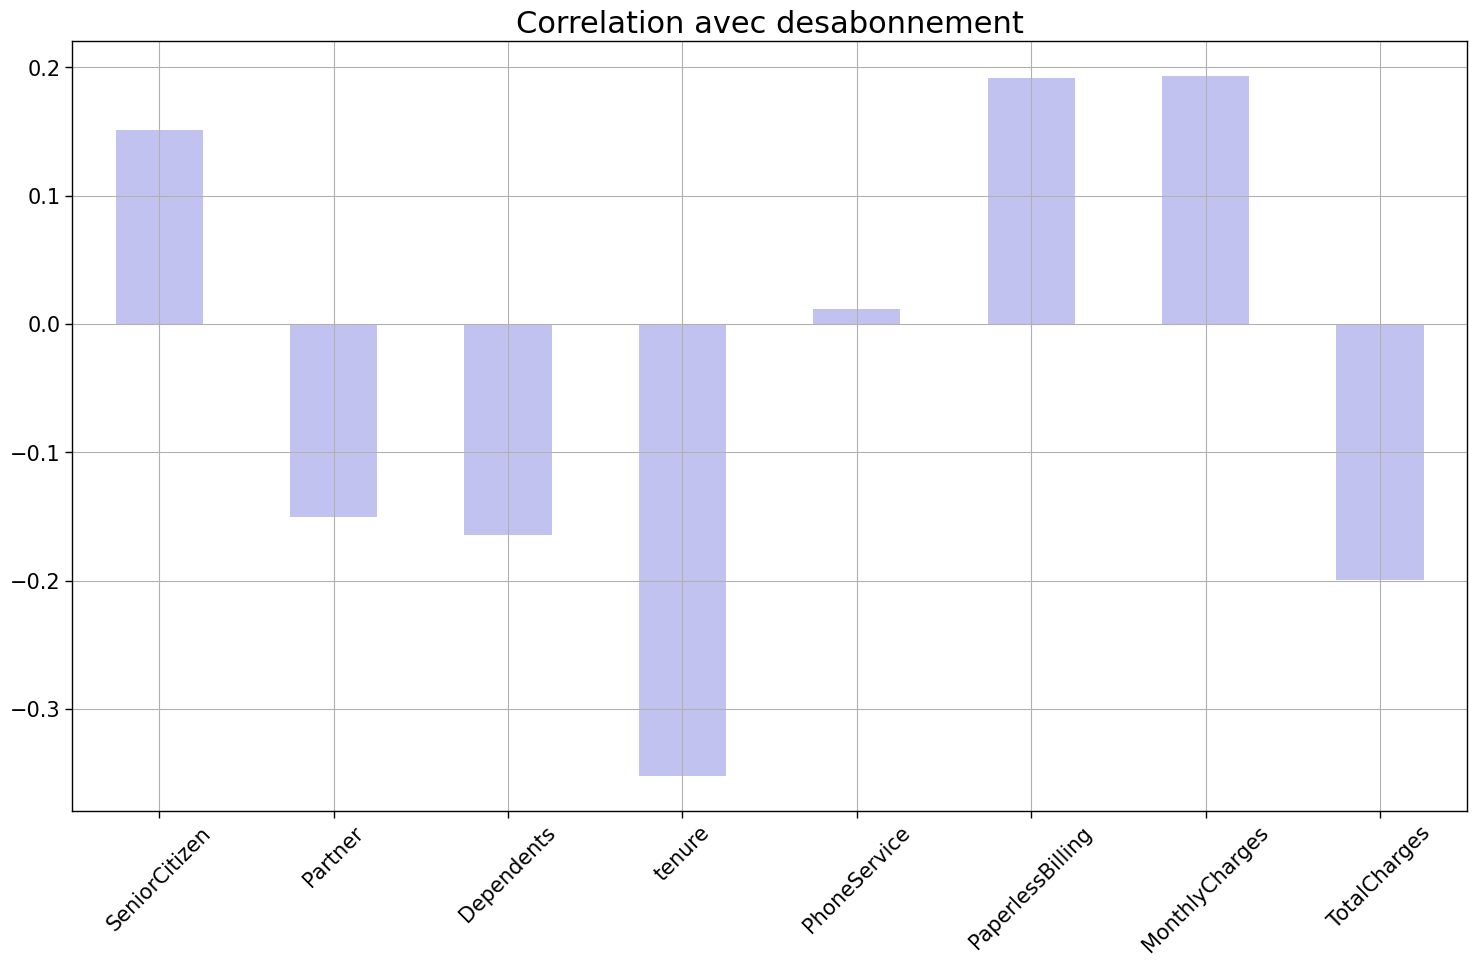

In [22]:
plt.figure
ds_corr = df[['SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling',
        'MonthlyCharges', 'TotalCharges']]

correlations = ds_corr.corrwith(df.Churn)
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (18, 10),
        fontsize = 15,
        color = '#c2c2f0',
        rot = 45, grid = True)

plt.title('Correlation avec desabonnement', horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")

En ce qui concerne la corrélation positive avec le désabonnement , trois variables sont mentionnées : les clients séniors , la facturation électronique et les charges mensuelles :

* Il est possible d'interpréter que les clients séniors ont tendance à se
désabonner. Les raisons pour cela pourraient être liées à des facteurs externes tels que la concurrence.
* Une relation positive entre les charges mensuelles et le désabonnement est explicable, car plus les montants facturés par mois sont élevés, plus il est probable que les clients se désabonnent.
* Une observation intéressante est que la facturation électronique est en réalité positivement corrélée au désabonnement.

En ce qui concerne la corrélation négative :

* Une ancienneté plus longue pourrait signifier la fidélité, ce qui se traduit par un risque de désabonnement moindre. Par conséquent, la relation négative est évidente.
* Contrairement à la relation entre les charges mensuelles et le désabonnement, il est intéressant de noter que les charges totales sont négativement corrélées au désabonnement. La raison peut être que les charges totales dépendent du temps que le client a passé avec l'entreprise (comme l'ancienneté a également une relation négative). De plus, il reste une incertitude quant à savoir si cette variable est suivie par le client afin de comprendre le comportement du client.

## Entrainement et comparaison de differents modeles de ML

In [ ]:
print(df.head())

   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1             

On affiche les 4 premieres lignes de la dataset pour s'assurer des modifications a faire avant d'entamer l'entrainement du modele.On effectue une copie sur notre dataset qu'on nomme dataset , on remplace les variables categorielles par 1/0 on defini la variable a predire y (churn) et la variable X qui contient le reste des colonnes. On divisera notre dataset en 0.7 pour l'entrainement et 0.3 pour le test.

In [ ]:
dataset = df.copy()
dataset = pd.get_dummies(dataset)
print(dataset.head())
X = dataset.drop(columns=['Churn'])
y = dataset['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1           29.85         29.85      0  ...   
1                 0           56.95       1889.50      0  ...   
2                 1           53.85        108.15      1  ...   
3                 0           42.30       1840.75      0  ...   
4                 1           70.70        151.65      1  ...   

   StreamingMovies_No  StreamingMovies_No internet service  \
0                   1                                    0   
1                   1                                    0

### **Modele SVM**

On declare maintenant notre algorithme SVM , on entraine notre modele sur les donnees et on affiche la precision du modele qu'on utilisera apres pour dresser un tableau de comparaison des differents algo.

In [ ]:
svm_model = SVC()

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred)

print(f"Précision du modèle SVM : {accuracy_svm}")

Précision du modèle SVM : 0.7352732434350603


### **Modele XGBoost**

On declare un autre algorithme XGBoost et on affichera sa precision aussi.

In [ ]:
xgboost_model = xgb.XGBClassifier()

xgboost_model.fit(X_train, y_train)

y_pred = xgboost_model.predict(X_test)

accuracy_xgboost = accuracy_score(y_test, y_pred)

print(f"Précision du modèle XGBoost: {accuracy_xgboost}")

Précision du modèle XGBoost: 0.7885024840312278


### **Modele ADABoost**

On declare un autre algorithme Adaboost en utilisant comme classifier de base Decision Tree et on affiche sa precision.

In [ ]:
base_classifier = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_classifier, n_estimators=50, learning_rate=1.0)

adaboost_model.fit(X_train, y_train)

y_pred = adaboost_model.predict(X_test)

accuracy_adaboost = accuracy_score(y_test, y_pred)

print(f"Précision du modèle AdaBoost: {accuracy_adaboost}")

Précision du modèle AdaBoost: 0.815471965933286


### **Modele KNN**

On declare un autre algorithme KNN et on calculera sa precision

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3)

knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

print(f"Précision du modèle KNN: {accuracy_knn}")

Précision du modèle KNN: 0.7700496806245565


### **Modele Logistic Regression**

On declare un autre algorithme Logistic Regression et on calculera sa precision

In [ ]:
logistic_model = LogisticRegression()

logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred)

print(f"Précision du modèle LR: {accuracy_lr}")

Précision du modèle LR: 0.8232789212207239


## **Definition de la fonction du metaheuristic TLBO**

On passe a la deuxieme partie ou on implementera un metaheuristic pour trouver les meilleurs parametres pour l'algorithme SVM le metaheuristic qu'on utilisera c'est TLBO, on definera sa fonction objective qui calculera la precision du modele , et on implementera la fonction tlbo qui va retourner les meilleurs parametres , et vers la fin on affichera les meilleurs parametres du modele ainsi que sa precision.

In [ ]:
def objective_function(C, kernel):
    kernel_map = {0: 'linear', 1: 'rbf', 2: 'poly', 3: 'sigmoid'}
    rounded_kernel = int(round(kernel) % len(kernel_map))
    svm = SVC(C=C, kernel=kernel_map[rounded_kernel])
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy

num_learners = 10
num_iterations = 10
search_space = [(0.1, 10.0), 0, 1, 2, 3]

def tlbo(num_learners, num_iterations, search_space):
    population = []

    for _ in range(num_learners):
        individual = [np.random.uniform(search_space[0][0], search_space[0][1]), np.random.choice(search_space[2:])]
        population.append(individual)

    for _ in range(num_iterations):
        fitness = [objective_function(*individual) for individual in population]

        sorted_indices = np.argsort(fitness)

        best_individual = population[sorted_indices[0]]
        worst_individual = population[sorted_indices[-1]]

        new_worst_individual = [best + np.random.uniform(-1, 1) * (best - worst) for best, worst in zip(best_individual, worst_individual)]

        population[sorted_indices[-1]] = new_worst_individual

    best_solution = population[sorted_indices[0]]
    best_fitness = -fitness[sorted_indices[0]]

    return best_solution, best_fitness


best_hyperparameters, best_accuracy = tlbo(num_learners, num_iterations, search_space)
best_C, best_kernel = best_hyperparameters
kernel_map = {0: 'linear', 1: 'rbf', 2: 'poly', 3: 'sigmoid'}
print("Best C:", best_C)
print("Best Kernel:", kernel_map[int(round(best_kernel) % len(kernel_map))])
print("Best Accuracy:", best_accuracy)

Best C: 4.665674939989142
Best Kernel: linear
Best Accuracy: 0.7892122072391767


### **Comparaison des precisions des modeles**

On affiche ci dessous une table ainsi qu'un plot pour comparer les precisions des modeles implementes.

            Model Name  Accuracy
0                  SVM  0.735273
1              XGBoost  0.788502
2             AdaBoost  0.815472
3                  KNN  0.770050
4  Logistic Regression  0.823279
5             SVM TLBO  0.789212


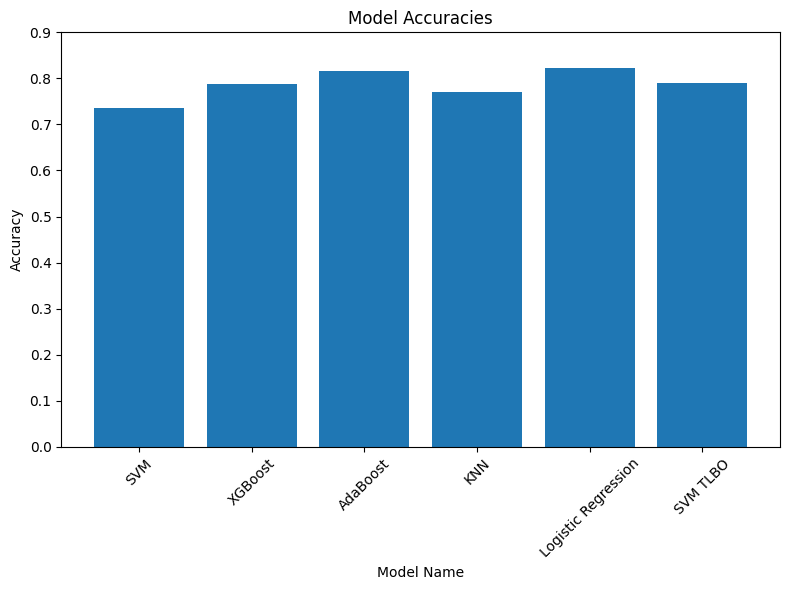

In [ ]:
model_data = {
    'Model Name': ['SVM', 'XGBoost', 'AdaBoost', 'KNN', 'Logistic Regression', 'SVM TLBO'],
    'Accuracy': [accuracy_svm, accuracy_xgboost, accuracy_adaboost, accuracy_knn, accuracy_lr, best_accuracy]
}
df = pd.DataFrame(model_data)
print(df)
plt.figure(figsize=(8, 6))
plt.bar(df['Model Name'], df['Accuracy'])
plt.xlabel('Model Name')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.ylim(0, 0.9)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


On remarque que le modele avec les meilleurs resultats est Logistic Regression suivi par ADAboost et suivi par SVM Tlbo , on remarque que l application d'un metaheuristic pour trouver les meilleurs parametres consomment beaucoup de temps et de ressource mais offre des resultats un peu mieux que le modele avec des parametres par defaut.